# Shared patterns of ILS across chromosomes

In [ ]:
%matplotlib inline

%env http_proxy=http://proxy-default:3128
%env https_proxy=http://proxy-default:3128

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings
from scipy import signal, stats
from statsmodels.nonparametric.smoothers_lowess import lowess

import sklearn
import numpy as np
from sklearn.preprocessing import quantile_transform

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#import mpld3

from horizonplot import horizonplot
from chromwindow import window
import genominterv

# import mygene
#from geneinfo import geneinfo, geneplot, connect_mygene
import geneinfo.information as gi
#gi.email('kaspermunch@birc.au.dk')

import seaborn as sns
sns.set()
sns.set_style("ticks")
sns.set_context("notebook")

# scale down size of default plots
import matplotlib as mpl
scale = 0.9
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

def add_band(x_low, x_high, y_low=None, y_high=None, ax=None, color='gray', linewidth=0, alpha=0.5, zorder=0, **kwargs):
    "Plot a gray block on x interval"
    if ax is None:
        ax = plt.gca()
    if y_low is None:
        y_low, _ = ax.get_ylim()
    if y_high is None:
        _, y_high = ax.get_ylim()
    g = ax.add_patch(Rectangle((x_low, y_low), x_high-x_low, y_high-y_low, 
                 facecolor=color,
                 linewidth=linewidth,
                 alpha=alpha,
                 zorder=zorder,
                 **kwargs))

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

class left:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)
        
# My own paired palette replacing the last brown pair with violets
sns.color_palette('Paired').as_hex()
Paired = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
                            '#fdbf6f', '#ff7f00', '#cab2d6','#6a3d9a', '#e585cf', '#ad009d'])
#sns.palplot(Paired)
Infographics = sns.color_palette(['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792'])
#sns.palplot(Infographics)

chromosomes = list(map(str, range(1,23))) + ['X']

In [ ]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

In [ ]:
ax = gi.gene_plot('chrX', 100000000, 101000000, assembly='hg19', figsize=(7, 4), return_axes=3)
sns.despine()

In [ ]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

## ECH regions

In [ ]:
extended_peak_regions_10 = pd.read_hdf('/home/kmt/simons/faststorage/people/kmt/results/extended_peak_regions_5e-05_25%_10%.hdf')
extended_peak_regions_75 = pd.read_hdf('/home/kmt/simons/faststorage/people/kmt/results/extended_peak_regions_5e-05_25%_75%.hdf')
extended_peak_regions_90 = pd.read_hdf('/home/kmt/simons/faststorage/people/kmt/results/extended_peak_regions_5e-05_25%_90%.hdf')
human_chimp_low_ils_regions_chrX = pd.read_hdf('/home/kmt/simons/faststorage/people/kmt/results/human_chimp_low_ils_regions_chrX.hdf')

In [ ]:
(extended_peak_regions_90.end_pos - extended_peak_regions_90.start_pos).sum() / 1000000

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
df = pd.read_hdf('../results/low_ils_total.h5')
#plt.hist(df.low_ils_total)
plot_df = stairs(df)
plt.plot(plot_df.pos, plot_df.low_ils_total)
#plt.xlim(100000000, 120000000)
plt.xlim(15000000, 25000000)

## Load ILS data

HDF is written in `nb01_horizons.ipynb`:

In [ ]:
ils_data = pd.read_hdf('../results/ils_data.h5')
ils_data.head()

# Accumulate evidence of ILS proportion and skew across trios

Only use subset of analyses with intermediate amounts of ILS:

In [ ]:
global_mean_ils = ils_data.groupby(['analysis', 'names']).propils.mean().sort_values().to_frame().reset_index()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x='propils', y='names', data=global_mean_ils, color='b', ax=ax)
sns.despine()

## Select subset of analyses with intermediate ILS

Only consider a subset of analyses where mean ILS proportion is not close to either zero or 2/3:

In [ ]:
# analyses_subset = global_mean_ils.loc[(global_mean_ils.propils >= 0.1) & (global_mean_ils.propils <= 0.5), 'analysis']
# analyses_subset = global_mean_ils.loc[(global_mean_ils.propils >= 0.05) & (global_mean_ils.propils <= 0.5), 'analysis']
analyses_subset1 = global_mean_ils.loc[(global_mean_ils.propils < 0.1), 'analysis']
print(analyses_subset1)
analyses_subset2 = global_mean_ils.loc[(global_mean_ils.propils > 0.1), 'analysis']
print(analyses_subset2)

## Mean proportion of ILS

In [ ]:
fig, ax = plt.subplots(23, 1, figsize=(16*3/2, 11*3/2))
for i, chrom in enumerate(chromosomes):
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset1)]
               .groupby(['chrom', 'start', 'end'])
               .propils
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.propils)
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset2)]
               .groupby(['chrom', 'start', 'end'])
               .propils
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.propils)
    ax[i].set_title(f'Chromosome {chrom}:', loc='left')
    plt.subplots_adjust(hspace=0.4)  

In [ ]:
fig, ax = plt.subplots(23, 1, figsize=(12, 40))
for i, chrom in enumerate(chromosomes):
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset1)]
               .groupby(['chrom', 'start', 'end'])
               .propils
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.propils)
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset2)]
               .groupby(['chrom', 'start', 'end'])
               .propils
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.propils)    
    ax[i].set_title(f'Chromosome {chrom}:', loc='left')
    plt.subplots_adjust(hspace=0.4)   

## Mean ILS qnorm

In [ ]:
fig, ax = plt.subplots(23, 1, figsize=(12, 40), sharey=True)
for i, chrom in enumerate(chromosomes):
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset1)]
               .groupby(['chrom', 'start', 'end'])
               .propils_qnorm
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.propils_qnorm)#, color='C1')
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset2)]
               .groupby(['chrom', 'start', 'end'])
               .propils_qnorm
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.propils_qnorm)#, color='C2')    
    ax[i].set_title(f'Chromosome {chrom}:', loc='left')
    plt.subplots_adjust(hspace=0.4)   

## Mean absolute V2-V3 difference

In [ ]:
fig, ax = plt.subplots(23, 1, figsize=(12, 40), sharey=True)
for i, chrom in enumerate(chromosomes):
    plot_df = (ils_data
               .assign(v2v3diff=lambda df: np.absolute(df.V2 - df.V3))
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset1)]
               .groupby(['chrom', 'start', 'end'])
               .v2v3diff
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.v2v3diff)#, color='C2')
    plot_df = (ils_data
               .assign(v2v3diff=lambda df: np.absolute(df.V2 - df.V3))
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset2)]
               .groupby(['chrom', 'start', 'end'])
               .v2v3diff
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.v2v3diff)#, color='C2')
    ax[i].set_title(f'Chromosome {chrom}:', loc='left')
    plt.subplots_adjust(hspace=0.4)  

## Mean *absolute* ILS z norm

I.e, where is the ILS either high or low

In [ ]:
def absmean(sr):
    return np.absolute(sr).mean()

fig, ax = plt.subplots(23, 1, figsize=(12, 40), sharey=True)
for i, chrom in enumerate(chromosomes):
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset1)]
               .groupby(['chrom', 'start', 'end'])
               .propils_znorm
               .agg(absmean)
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.propils_znorm, linewidth=0.3)
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset2)]
               .groupby(['chrom', 'start', 'end'])
               .propils_znorm
               .agg(absmean)
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.propils_znorm, linewidth=0.3)
    
    tax = ax[i].twinx()
    
    plot_df = (ils_data
               .assign(v2v3diff=lambda df: np.absolute(df.V2 - df.V3))
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset1)]
               .groupby(['chrom', 'start', 'end'])
               .v2v3diff
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    tax.plot(plot_df.pos, plot_df.v2v3diff, linewidth=0.3)
    plot_df = (ils_data
               .assign(v2v3diff=lambda df: np.absolute(df.V2 - df.V3))
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset2)]
               .groupby(['chrom', 'start', 'end'])
               .v2v3diff
               .agg('mean')
               .reset_index()
               .pipe(stairs)
              )
    tax.plot(plot_df.pos, plot_df.v2v3diff, linewidth=0.3)
    
    ax[i].set_title(f'Chromosome {chrom}:', loc='left')
    plt.subplots_adjust(hspace=0.4)  

In [ ]:
plot_df1 = (ils_data
           .loc[(ils_data.chrom == 'X') & ils_data.analysis.isin(analyses_subset1)]
           .groupby(['chrom', 'start', 'end'])
           .propils_znorm
           .agg(absmean)
           .reset_index()
           .pipe(stairs)
          )
plot_df2 = (ils_data
           .loc[(ils_data.chrom == 'X') & ils_data.analysis.isin(analyses_subset2)]
           .groupby(['chrom', 'start', 'end'])
           .propils_znorm
           .agg(absmean)
           .reset_index()
           .pipe(stairs)
          )

In [ ]:
ax = gi.gene_plot('chrX', 0, 160000000, assembly='hg19', figsize=(16*3/2, 11*3/2), aspect=4, gene_density=180, font_size=4)
ax[0].plot(plot_df1.pos, plot_df1.propils_znorm) ;
ax[0].plot(plot_df2.pos, plot_df2.propils_znorm) ;
# for tup in extended_peak_regions_75.itertuples():
#     add_band(tup.start_pos, tup.end_pos, ax=ax)

In [ ]:
ax = gi.gene_plot('chrX', 0, 160000000, assembly='hg19', figsize=(16*3/2, 11*3/2), aspect=4, gene_density=180, font_size=4)
ax[0].plot(plot_df1.pos, np.log10(plot_df1.propils_znorm)) ;
ax[0].plot(plot_df2.pos, np.log10(plot_df2.propils_znorm)) ;
# for tup in extended_peak_regions_75.itertuples():
#     add_band(tup.start_pos, tup.end_pos, ax=ax)

In [ ]:
# ax = gi.gene_plot('chrX', 47500000, 60000000, assembly='hg19', figsize=(12, 7), aspect=2)
# ax.plot(plot_df.pos, plot_df.propils_znorm, color='C2') ;
# for tup in extended_peak_regions_75.itertuples():
#     add_band(tup.start_pos, tup.end_pos, ax=ax)

In [ ]:
ax, = gi.gene_plot('chrX', 70000000, 80000000, assembly='hg19', figsize=(12, 7), aspect=2)
ax.plot(plot_df1.pos, plot_df1.propils_znorm, color='C2') ;
ax.plot(plot_df2.pos, plot_df2.propils_znorm, color='C2') ;
for tup in extended_peak_regions_75.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)

In [ ]:
ax, = gi.gene_plot('chrX', 102000000, 112000000, assembly='hg19', figsize=(12, 7), aspect=2)
ax.plot(plot_df1.pos, plot_df1.propils_znorm, color='C2') ;
ax.plot(plot_df2.pos, plot_df2.propils_znorm, color='C2') ;
for tup in extended_peak_regions_75.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)

In [ ]:
ax, = gi.gene_plot('chrX', 115000000, 125000000, assembly='hg19', figsize=(12, 7), aspect=2)
ax.plot(plot_df1.pos, plot_df1.propils_znorm, color='C2') ;
ax.plot(plot_df2.pos, plot_df2.propils_znorm, color='C2') ;
for tup in extended_peak_regions_75.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)

In [ ]:
ax, = gi.gene_plot('chrX', 135000000, 145000000, assembly='hg19', figsize=(12, 7), aspect=2)
ax.plot(plot_df1.pos, plot_df1.propils_znorm, color='C2') ;
ax.plot(plot_df2.pos, plot_df2.propils_znorm, color='C2') ;
for tup in extended_peak_regions_75.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)

In [ ]:
ax, = gi.gene_plot('chrX', 150000000, 156000000, assembly='hg19', figsize=(12, 7), aspect=2)
ax.plot(plot_df1.pos, plot_df1.propils_znorm, color='C2') ;
ax.plot(plot_df2.pos, plot_df2.propils_znorm, color='C2') ;
for tup in extended_peak_regions_75.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)

## Mean of absolute skew z norm

In [ ]:
def absmean(sr):
    return np.absolute(sr).mean()

fig, ax = plt.subplots(23, 1, figsize=(12, 40))
for i, chrom in enumerate(chromosomes):
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset1)]
               .groupby(['chrom', 'start', 'end'])
               .ilsskew_znorm
               .agg(absmean)
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.ilsskew_znorm)
    plot_df = (ils_data
               .loc[(ils_data.chrom == chrom) & ils_data.analysis.isin(analyses_subset2)]
               .groupby(['chrom', 'start', 'end'])
               .ilsskew_znorm
               .agg(absmean)
               .reset_index()
               .pipe(stairs)
              )
    ax[i].plot(plot_df.pos, plot_df.ilsskew_znorm)
    ax[i].set_title(f'Chromosome {chrom}:', loc='left')
    plt.subplots_adjust(hspace=0.4)   

## X chromosome

In [ ]:
ils_data.head()

In [ ]:
# skew_var = 'ilsskew'
# ils_var = 'propils_znorm'
# min_propils = 1
# max_propils = 0
# min_ilsskew = 0.5

# outliers = (ils_data[ils_var] > min_propils) & (ils_data[skew_var] > min_ilsskew) | (ils_data[ils_var] < max_propils)
# ils_data['outlier'] = outliers

# gr = ils_data.loc[(ils_data.chrom == 'X') & ils_data.analysis.isin(analyses_subset)].groupby(['chrom', 'start', 'end'])

# plot_df = gr.outlier.agg('sum').reset_index().pipe(stairs)

# plt.hist(plot_df.outlier, bins=100) ;

In [ ]:
#plot_df

In [ ]:
# gr = ils_data.loc[(ils_data.chrom == 'X') & ils_data.analysis.isin(analyses_subset)].groupby(['chrom', 'start', 'end'])

# fig, ax = plt.subplots(1, 1, figsize=(18, 6))

# ax.plot(plot_df.pos, plot_df.outlier)
# for tup in extended_peak_regions_90.itertuples():
#     add_band(tup.start_pos, tup.end_pos, ax=ax)

In [ ]:
# skew_var = 'ilsskew'
# ils_var = 'propils_znorm'
# min_propils = 1
# max_propils = 0
# min_ilsskew = 0.5

skew_var = 'ilsskew'
ils_var = 'propils'
min_propils = 0.08
max_propils = 0
min_ilsskew = 0

# skew_var = 'ilsskew_znorm'
# ils_var = 'propils_znorm'
# min_propils = 1
# max_propils = 10
# min_ilsskew = 1


# skew_var = 'ilsskew'
# ils_var = 'propils_znorm'
# min_propils = 1
# max_propils = 0
# min_ilsskew = 0.4

# skew = 'ilsskew_znorm'
# min_propils = 0.3
# max_propils = 0.5
# min_ilsskew = 0.5

gr = ils_data.loc[(ils_data.chrom == 'X') & ils_data.analysis.isin(analyses_subset1)].groupby(['chrom', 'start', 'end'])
plot_df = gr[['start', 'end', ils_var, skew_var]].agg(absmean).reset_index().pipe(stairs)

outliers1 = (plot_df[ils_var] > min_propils) & (plot_df[skew_var] > min_ilsskew) | (plot_df[ils_var] < max_propils)
#outliers = (plot_df.propils < max_propils)

plt.figure(figsize=(7, 5))
plt.scatter(plot_df[ils_var], plot_df[skew_var], alpha=0.1) ; 
plt.scatter(plot_df.loc[outliers1, ils_var], plot_df.loc[outliers1, skew_var], alpha=0.2, color='red') ; 
plt.axhline(y=min_ilsskew, color='black', linestyle='dashed')
plt.axvline(x=min_propils, color='black', linestyle='dashed')
plt.axvline(x=max_propils, color='black', linestyle='dashed')
plt.xlabel(ils_var)
plt.ylabel(skew_var)
plot_df.loc[outliers1, ['chrom', 'start', 'end', ils_var, skew_var]].to_hdf('../results/high_ils_high_skew.h5', 'df')

In [ ]:
skew_var = 'ilsskew'
ils_var = 'propils'
min_propils = 1
max_propils = 0.3
min_ilsskew = 0.4

# skew_var = 'ilsskew_znorm'
# ils_var = 'propils_znorm'
# min_propils = 10
# max_propils = 0.5
# min_ilsskew = 1

gr = ils_data.loc[(ils_data.chrom == 'X') & ils_data.analysis.isin(analyses_subset2)].groupby(['chrom', 'start', 'end'])
plot_df = gr[['start', 'end', ils_var, skew_var]].agg(absmean).reset_index().pipe(stairs)

outliers2 = (plot_df[ils_var] > min_propils) & (plot_df[skew_var] > min_ilsskew) | (plot_df[ils_var] < max_propils)
#outliers = (plot_df.propils < max_propils)

plt.figure(figsize=(7, 5))
plt.scatter(plot_df[ils_var], plot_df[skew_var], alpha=0.1) ; 
plt.scatter(plot_df.loc[outliers2, ils_var], plot_df.loc[outliers2, skew_var], alpha=0.2, color='red') ; 
plt.axhline(y=min_ilsskew, color='black', linestyle='dashed')
plt.axvline(x=min_propils, color='black', linestyle='dashed')
plt.axvline(x=max_propils, color='black', linestyle='dashed')
plt.xlabel(ils_var)
plt.ylabel(skew_var)
plot_df.loc[outliers2, ['chrom', 'start', 'end', ils_var, skew_var]].to_hdf('../results/high_ils_high_skew.h5', 'df')

In [ ]:
ils_sel_interv = genominterv.interval_collapse(plot_df.loc[outliers1 & outliers2, ['chrom', 'start', 'end']].drop_duplicates())
ils_sel_interv.head()

In [ ]:
# ils_sel_interv = genominterv.interval_collapse(plot_df.loc[outliers, ['chrom', 'start', 'end']].drop_duplicates())
# ils_sel_interv.head()

In [ ]:
#ils_sel_interv = genominterv.interval_collapse(plot_df.loc[outliers, ['chrom', 'start', 'end']].drop_duplicates()).loc[:, ['chrom', 'start', 'end']] << left()

In [ ]:
#fig, ax = plt.subplots(4, 1, figsize=(18, 10))

ax = gi.gene_plot('chrX', 0, 160000000, assembly='hg19', figsize=(16*3/2, 16*3/2), aspect=2, gene_density=180, font_size=4, return_axes=4)


gr = ils_data.loc[(ils_data.chrom == 'X') & ils_data.analysis.isin(analyses_subset1)].groupby(['chrom', 'start', 'end'])

plot_df = gr.propils.agg('mean').reset_index().pipe(stairs)
ax[0].plot(plot_df.pos, plot_df.propils)
ax[0].set_title('Mean proportion ILS', loc='left')
    
plot_df = gr.propils_qnorm.agg('mean').reset_index().pipe(stairs)
ax[1].plot(plot_df.pos, plot_df.propils_qnorm)
ax[1].set_title('Mean proportion ILS q norm', loc='left')
    
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax[2].plot(plot_df.pos, plot_df.ilsskew)
ax[2].set_title('ILS skew', loc='left')

plot_df = gr.ilsskew_znorm.agg(absmean).reset_index().pipe(stairs)
ax[3].plot(plot_df.pos, plot_df.ilsskew_znorm)
ax[3].set_title('ILS skew z norm', loc='left')

    
gr = ils_data.loc[(ils_data.chrom == 'X') & ils_data.analysis.isin(analyses_subset2)].groupby(['chrom', 'start', 'end'])

plot_df = gr.propils.agg('mean').reset_index().pipe(stairs)
ax[0].plot(plot_df.pos, plot_df.propils)
ax[0].set_title('Mean proportion ILS', loc='left')
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax[0])
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax[0], color='red', alpha=0.5)    
    
plot_df = gr.propils_qnorm.agg('mean').reset_index().pipe(stairs)
ax[1].plot(plot_df.pos, plot_df.propils_qnorm)
ax[1].set_title('Mean proportion ILS q norm', loc='left')
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax[1])
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax[1], color='red', alpha=0.5)     
    
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax[2].plot(plot_df.pos, plot_df.ilsskew)
ax[2].set_title('ILS skew', loc='left')
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax[2])
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax[2], color='red', alpha=0.5)     

plot_df = gr.ilsskew_znorm.agg(absmean).reset_index().pipe(stairs)
ax[3].plot(plot_df.pos, plot_df.ilsskew_znorm)
ax[3].set_title('ILS skew z norm', loc='left')
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax[3])
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax[3], color='red', alpha=0.5)  
    
    
plt.tight_layout()

In [ ]:
ils_sel_interv << left()

In [ ]:
idx = 0
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5)   

In [ ]:
idx = 1
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5)   

In [ ]:
idx = 2
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 3
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 4
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 5
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 6
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 7
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 8
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 9
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 10
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

In [ ]:
idx = 11
start, end = ils_sel_interv.loc[idx, 'start'], ils_sel_interv.loc[idx, 'end']
start, end = start-200000, end+200000
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax, = gi.gene_plot('chrX', start, end, assembly='hg19', figsize=(12, 5))
ax.plot(plot_df.pos, plot_df.ilsskew)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)  
for tup in ils_sel_interv.itertuples():
    add_band(tup.start, tup.end, ax=ax, color='red', alpha=0.5) 

511, **NUDT10** 

728, 729, **CHIC1** nDEG

1328, 

760 - 763: just the right of ARTX sweep, just like in baboons

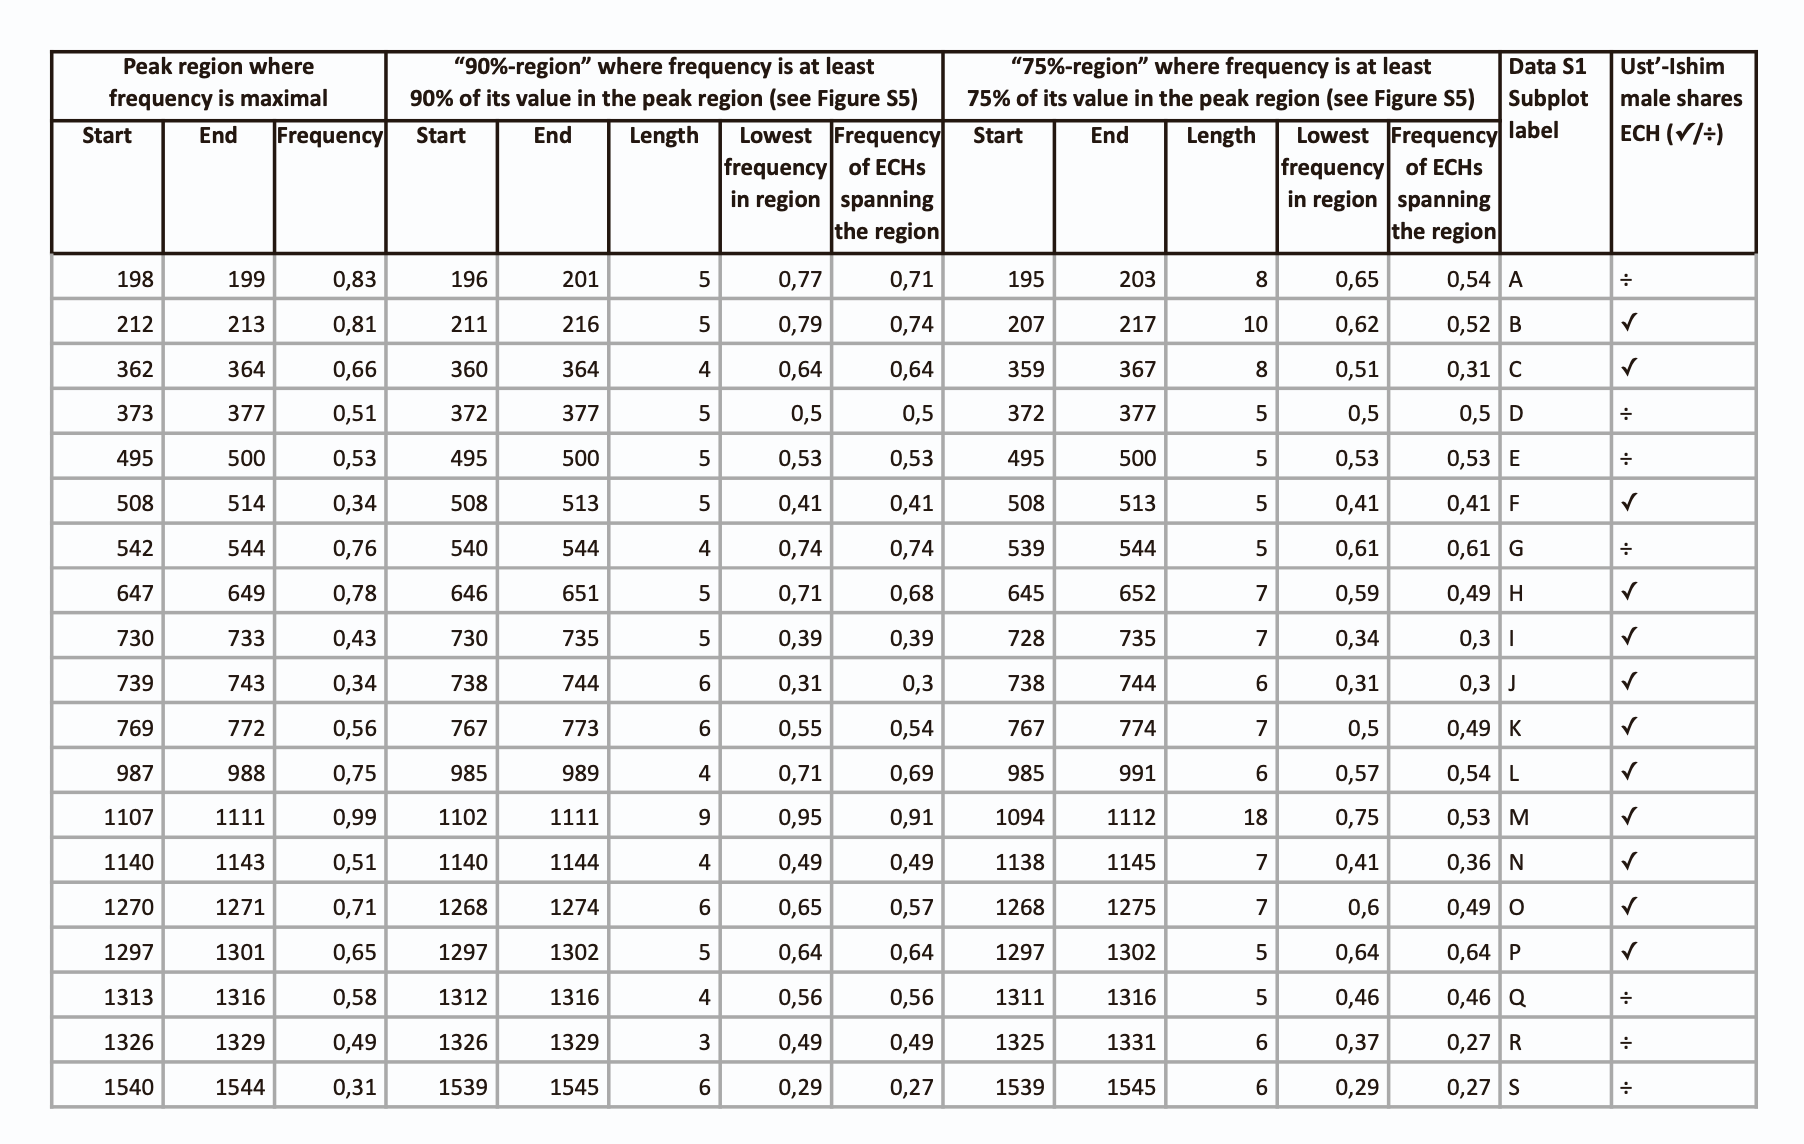

### Detail of 3 chromosome region

In [ ]:
gr = ils_data.loc[(ils_data.chrom == '3') & (ils_data.start > 45e6) & (ils_data.end < 55e6) \
                  & ils_data.analysis.isin(analyses_subset)].groupby(['chrom', 'start', 'end'])

fig, ax = plt.subplots(4, 1, figsize=(12, 10))

plot_df = gr.propils.agg('mean').reset_index().pipe(stairs)
ax[0].plot(plot_df.pos, plot_df.propils)
ax[0].set_title('Mean proportion ILS', loc='left')
    
plot_df = gr.propils_z_score.agg('mean').reset_index().pipe(stairs)
ax[1].plot(plot_df.pos, plot_df.propils_z_score)
ax[1].set_title('Mean proportion ILS z-score', loc='left')
    
plot_df = gr.ilsskew.agg(absmean).reset_index().pipe(stairs)
ax[2].plot(plot_df.pos, plot_df.ilsskew)
ax[2].set_title('ILS skew', loc='left')

# plot_df = gr.ilsskew_z_score.agg(absmean).reset_index().pipe(stairs)
# ax[3].plot(plot_df.pos, plot_df.ilsskew_z_score)
# ax[3].set_title('ILS skew z-score', loc='left')

## Load low ils regions

In [ ]:
low_ils_reg = pd.read_csv('../steps/merge_low_data/merged_low_ils_regions.csv').sort_values(by=['start', 'end'])
low_ils_reg.head()

In [ ]:
@window(size=100000, fill='hg38')
def low_ils_total(df):
    return (df.end-df.start).sum()

low_ils_totals = (low_ils_reg
                  .loc[low_ils_reg.analysis.isin(analyses_subset)]
                  .groupby('chrom')
                  .apply(low_ils_total)
                  .reset_index(drop=True, level=-1)
                  .reset_index()
                 )
low_ils_totals.head()

In [ ]:
plot_df = stairs(low_ils_totals)
g = sns.FacetGrid(plot_df, row='chrom', height=2, aspect=7, row_order=chromosomes)
g.map(plt.plot,'pos', 'low_ils_total') ;

### Chromosome 3 region detail 

In [ ]:
mg = mygene.MyGeneInfo()
connect_mygene(mg)

In [ ]:
chrom, start, end = 'chr3', 49500000, 50500000
ax = geneplot(chrom, start, end, figsize=(10, 5))

ax.plot(np.linspace(start, end, 1000), np.random.random(1000), 'o') ;

mpld3.display()

In [ ]:
plot_df = stairs(low_ils_totals.loc[lambda df: (df.chrom == '3') &(df.start >= 45e6) & (df.end < 55e6)])
plt.plot(plot_df.pos, plot_df.low_ils_total) ;

### Chromosome X detail 

In [ ]:
plt.figure(figsize=(18, 5))
plot_df = stairs(low_ils_totals.loc[lambda df: (df.chrom == 'X')])
plt.plot(plot_df.pos, plot_df.low_ils_total)
for tup in extended_peak_regions_90.itertuples():
    add_band(tup.start_pos, tup.end_pos, color='grey')
for tup in human_chimp_low_ils_regions_chrX.itertuples():
    add_band(tup.start, tup.end, color='pink')

In [ ]:
plot_df.loc[plot_df.low_ils_total >= 2, ['chrom', 'start', 'end', 'low_ils_total']].to_hdf('../results/low_ils_total.h5', 'df')

In [ ]:
pd.read_hdf('../results/high_ils_high_skew.h5')

In [ ]:
pd.read_hdf('../results/low_ils_total.h5')

## Gene plots / Enrichment / Heat propagation / GOATOOLS